In [ ]:
!pip install eod
!pip install nelson-siegel-svensson
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt


In [ ]:
import yfinance as yf
import datetime

# Importing data
def get_data(stocks, start, end):
    data = yf.download(stocks, start=start, end=end)
    return data
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)

stock_prices = yf.download('^NSEI', startDate, endDate)
print(startDate)
stock_prices.head()

/tmp/ipython-input-2690493254.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_prices = yf.download('^NSEI', startDate, endDate)
[*********************100%***********************]  1 of 1 completed

2006-10-30 10:33:44.933184


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2007-09-17,4494.649902,4549.049805,4482.850098,4518.450195,0
2007-09-18,4546.200195,4551.799805,4481.549805,4494.100098,0
2007-09-19,4732.350098,4739.000000,4550.250000,4550.250000,0
2007-09-20,4747.549805,4760.850098,4721.149902,4734.850098,0
2007-09-21,4837.549805,4855.700195,4733.700195,4752.950195,0


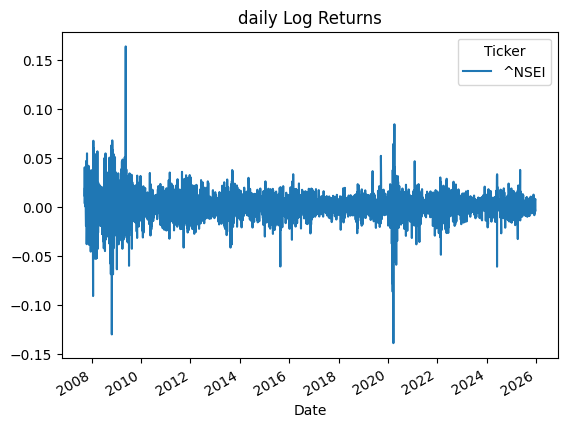

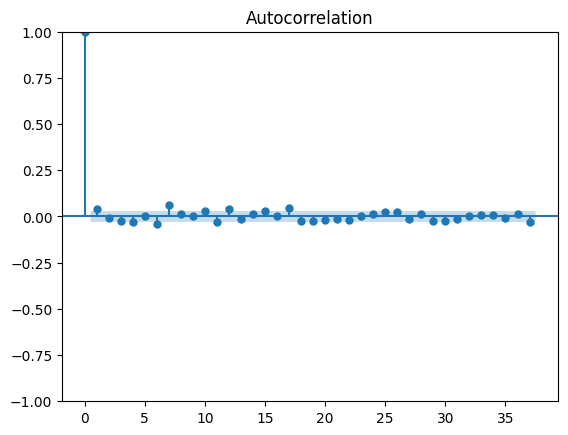

In [ ]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily Log Returns')
plot_acf(log_returns)
plt.show()

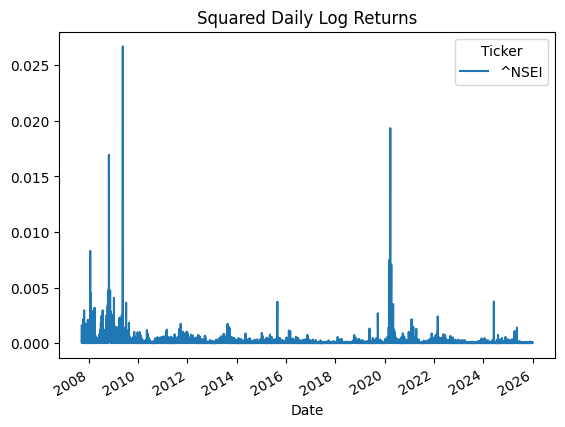

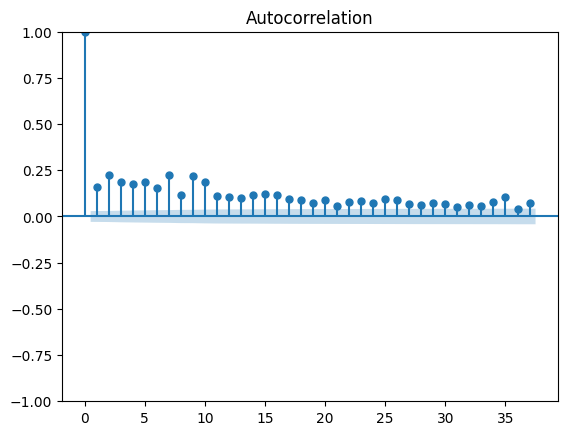

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('Squared Daily Log Returns')
plot_acf(log_returns_sq)
plt.show()

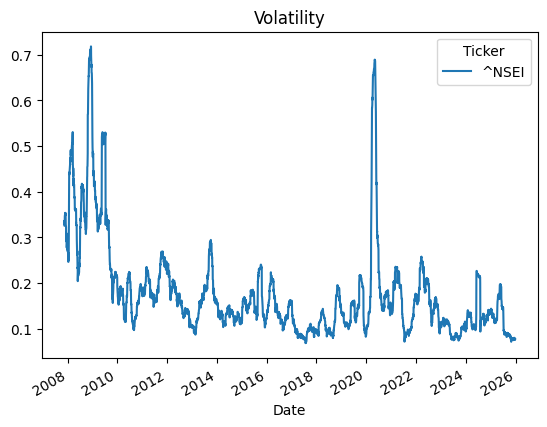

In [ ]:
TRADING_DAYS = 40
volatility = log_returns.rolling(TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('Volatility')
plt.show()

In [ ]:
def MLE_norm(x):
  mu_hat = np.mean(x)
  sigma2_hat = np.var(x)
  return mu_hat, sigma2_hat




In [ ]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=N)

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = '$\\hat{\\mu} = '+format(round(mu_hat, 2))+'$'
for_sigma2_hat = '$\\hat{\\sigma} = '+format(round(np.sqrt(sigma2_hat), 2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
# Performing MLE Numerically

def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]

    l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma)))

    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [11]:
import numpy as np
import scipy as sc
from IPython.display import display, Latex

# Define x as it was defined in a previous cell
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=N)

# Performing MLE Numerically
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]

    # Ensure sigma is positive to avoid issues with normal distribution
    sigma = np.maximum(sigma, 1e-8)

    pdf_values = sc.stats.norm.pdf(x, loc=mu, scale=sigma)
    # Ensure pdf_values are not zero before taking log to prevent log of zero warnings
    pdf_values = np.maximum(pdf_values, 1e-100)

    l_theta = np.sum(np.log(pdf_values))

    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

cons_set = {'type': 'ineq', 'fun': sigma_pos}

theta0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta0, args=(x), constraints=cons_set)

for_mu_hat = r'$\hat{\mu} = ' + format(round(opt.x[0], 2)) + r'$'
for_sigma2_hat = r'$\hat{\sigma} = ' + format(round(np.sqrt(opt.x[1]**2), 2)) + r'$' # Use opt.x[1] as sigma and square it for sigma^2 then sqrt it again for sigma

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))


The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [15]:
import numpy as np
import scipy as sc
import yfinance as yf
import datetime
from IPython.display import display, Latex

# Code from previous cells to define volatility
# Define stock_prices
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)
stock_prices = yf.download('^NSEI', startDate, endDate)

log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
TRADING_DAYS = 40
volatility = log_returns.rolling(TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()

# Performing the MLE of the Ornstein-Uhlenbeck Process

def mu(x, dt, kappa, theta):
  ekt = np.exp(-kappa*dt)
  return (1-ekt)*theta + ekt*x

def std(dt, kappa, sigma):
  e2kt = np.exp(-2*kappa*dt)
  return sigma*np.sqrt((1-e2kt)/(2*kappa))

def log_likelihood_OU(theta_hat, x):
  kappa = theta_hat[0]
  theta = theta_hat[1]
  sigma = theta_hat[2]

  x_dt = x[1:]
  x_t = x[:-1]

  dt = 1/252

  mu_OU = mu(x_t, dt, kappa, theta)
  sigma_OU = std(dt, kappa, sigma)

  # Ensure sigma_OU is not zero or too small to prevent division by zero in PDF calculation
  sigma_OU = np.maximum(sigma_OU, 1e-8)

  pdf_values = sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)

  # Ensure pdf_values are not zero before taking log to prevent log of zero warnings
  pdf_values = np.maximum(pdf_values, 1e-100)

  l_theta_hat = np.sum( np.log(pdf_values))

  return -l_theta_hat


def kappa_pos(theta_hat):
  kappa = theta_hat[0]
  return kappa

def sigma_pos(theta_hat):
  sigma = theta_hat[2]
  return sigma

vol = np.array(volatility)

cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,1,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol), constraints=cons_set)

for_kappa_hat = r'$\hat{\kappa} = ' + format(round(opt.x[0], 2)) + r'$'
for_theta_hat = r'$\hat{\theta} = ' + format(round(opt.x[1], 2)) + r'$'
for_sigma_hat = r'$\hat{\sigma} = ' + format(round(opt.x[2], 2)) + r'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol[-1][0],3))

/tmp/ipython-input-3343192455.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_prices = yf.download('^NSEI', startDate, endDate)
[*********************100%***********************]  1 of 1 completed

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.076


The Parameters calculated using historical data of Nifty 50 Index shows that the mean reversion (kappa hat) occurs approximately every 0.6 years, the mean reverting process (theta hat) has a mean of 0.16, and has a standard deviation (sigma hat) of 0.12, with the last volatility recorded as 0.076, which could possibly indicate that the Index could enter another mean reverting process soon if volatility reaches closer to 0.12 during the first quater of 2026.

However, this is not entirely conclusive as NIFTY 50 is not the only heavily traded Index in Indian markets- SENSEX is another index not included in this model as this model focuses only on one Index. Which could possibly mitigate or aggrevate volaltily as Indian markets are historically known to be sentimental markets which could provide an explanation to for a moderately high volatility (sigma hat).

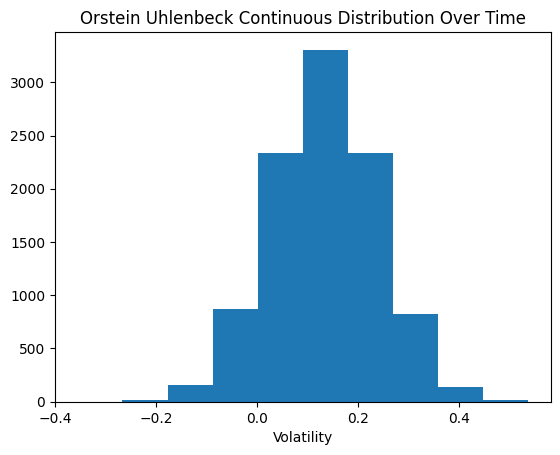

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Stimulating The Ornstein-Uhlenbeck Process


# Lets define the parameters

Time = 2
M = 10000
Z = np.random.normal(size=(M))

# Define initial volatility and estimated parameters from previous MLE
# 'vol' is assumed to be available from the execution of the previous cell (poYZbVoX4d_p)
# If 'vol' is not globally available, you would need to redefine it here.
# Based on the kernel state, 'vol' is available.
vol0 = vol[-1][0] # last observed volatility

# From the output of the MLE in the previous cell (poYZbVoX4d_p)
kappa = 0.59
theta = 0.16
sigma = 0.12

def mu(x, dt, kappa, theta):
  ekt = np.exp(-kappa*dt)
  return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
  e2kt = np.exp(-2*kappa*dt)
  return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU= std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z

plt.hist(vol_OU)
plt.title('Orstein Uhlenbeck Continuous Distribution Over Time')
plt.xlabel('Volatility')
plt.show()

As we can see the histogram naturally forms a bell curve like structure, which can attribute to why we performed the Maximum Log-likehood Estimator (MLE) on the normal distribution first and then proceeded to maximise the the Orstein-Uhlenbeck process, as the maximisation of the process causes the estimator to be similar to that of the normal distribution, which inturn aided us in providing fairly accurate estimators for the NIFTY 50 Index.

In conclusion, The Ornstein-Uhlenbeck Model can depict the volatility in the NIFTY 50 Index as a random walk and can be computated using Maximum Log-Likelihood Estimator (MLE) with sufficient past data of the index, and proves that volatility in markets although random, can return to stable levels which is depicted via the nature of the model being a continuous stochastic model.